The Air Passenger dataset provides monthly total of US airline passengers, from 1949 to 1960.
This dataset is of a time series class.
Objective:
•
Check for the stationarity of your data using Rolling Statistics and Dickey fuller test
•
If stationarity is present, remove it using differencing in Python

In [66]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,6
import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv("C:/Users/sharv/Documents/Post Graduate Program In Data Science-PurdueSimpliLearn/Course3-Machine Learning/Demo Datasets/Lesson 8/AirPassengers.csv")
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [67]:
data['Month'].head()

0    1949-01
1    1949-02
2    1949-03
3    1949-04
4    1949-05
Name: Month, dtype: object

In [68]:
# Let's display total monthly passenger count
data['Month']=data['Month'].apply(lambda x: dt(int(x[:4]),int(x[5:]),15)) # using lambda function to filter month
data=data.set_index("Month") # plot seting index to month
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


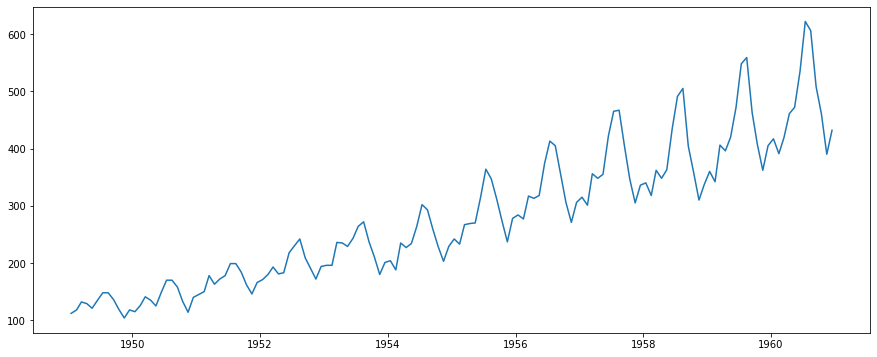

In [69]:
# assigning the passenger data time series variable 
ts=data['#Passengers']
plt.plot(ts)
# it is clear from the plot that there is overall increase in the trend with some seasonality in it.

In [70]:
# transforming series using log decomposition
ts_log = np.log(ts)
# stationarity check- writing function for rolling statistic and Dickey Fuller test
def test_stationarity(timeseries):
    rolmean=timeseries.rolling(window=52, center=False).mean()
    rolstd=timeseries.rolling(window=52, center=False).std()
    
# let's plot rolling statistics
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling mean')
    std=plt.plot(rolstd,color='black',label='Rolling std')

    plt.legend(loc='best')
    plt.title("Rolling mean and standard deviation")
    plt.show(block=False)
    
# Let's per form the Dickey FUller test
    print("Results of Dickey Fuller test:")
    dftest=adfuller(timeseries,autolag='AIC')
    # initialising 'Test Statistic','p-value', etc
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','Number of observations used'])
    # initialising critical value variable
    for key, value in dftest[4].items():
        dfoutput['Critical value(%s)'%key]=value
    print(dfoutput)

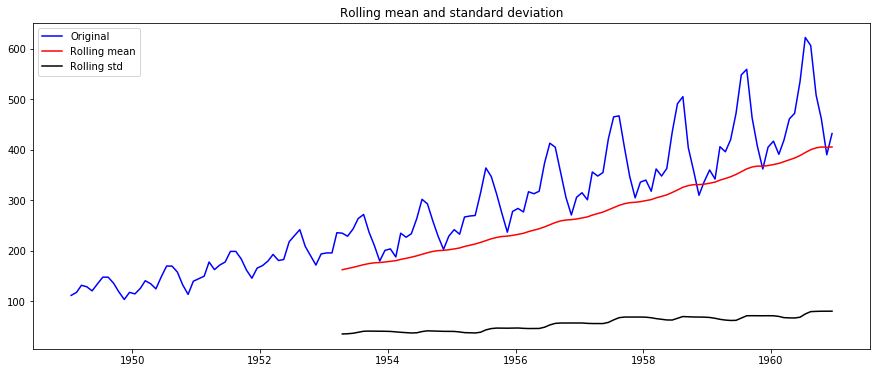

Results of Dickey Fuller test:
Test Statistic                   0.815369
p-value                          0.991880
#lags used                      13.000000
Number of observations used    130.000000
Critical value(1%)              -3.481682
Critical value(5%)              -2.884042
Critical value(10%)             -2.578770
dtype: float64


In [71]:
test_stationarity(data['#Passengers'])
# by observing th plot, test statistic > critical value and moving avg is not constant over time so Null hypothesis of 
# Dickey fuller test can not be rejected. This shows that the time series is not stationary.

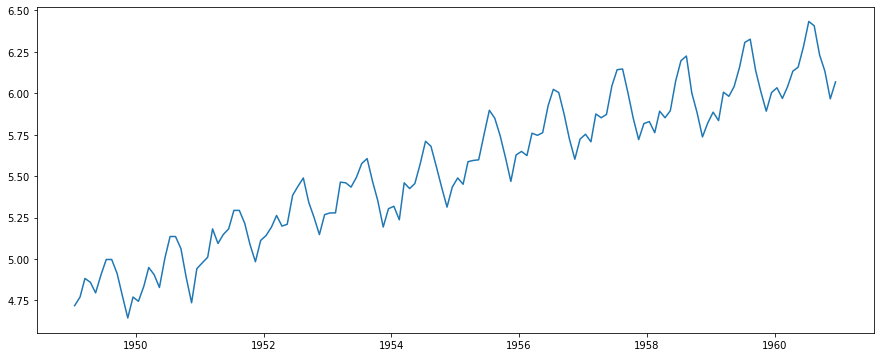

In [72]:
# decomposing the data. Also plot moving avg
plt.plot(ts_log)

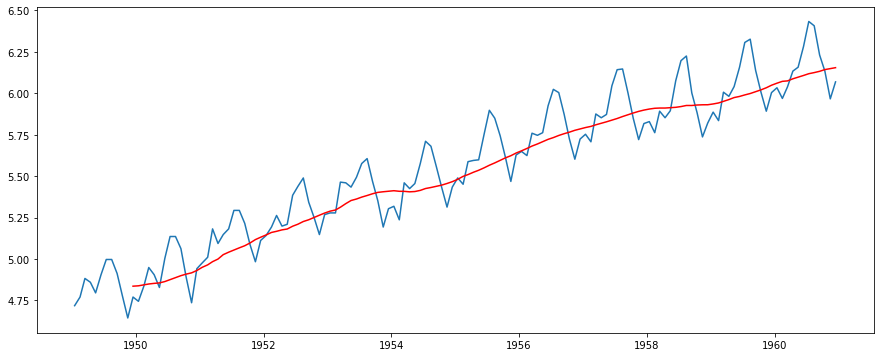

In [73]:
# initializing the moving avg variable
movingAverage=ts_log.rolling(window=12).mean()
movingSTD=ts_log.rolling(window=12).std()
plt.plot(ts_log) # plotting the data
plt.plot(movingAverage,color='red') # plotting the moving avg

In [74]:
ts_log_mv_diff=ts_log - movingAverage
ts_log_mv_diff.head(12)


Month
1949-01-15         NaN
1949-02-15         NaN
1949-03-15         NaN
1949-04-15         NaN
1949-05-15         NaN
1949-06-15         NaN
1949-07-15         NaN
1949-08-15         NaN
1949-09-15         NaN
1949-10-15         NaN
1949-11-15         NaN
1949-12-15   -0.065494
Name: #Passengers, dtype: float64

In [75]:
# Let's drop null values from time series data
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64

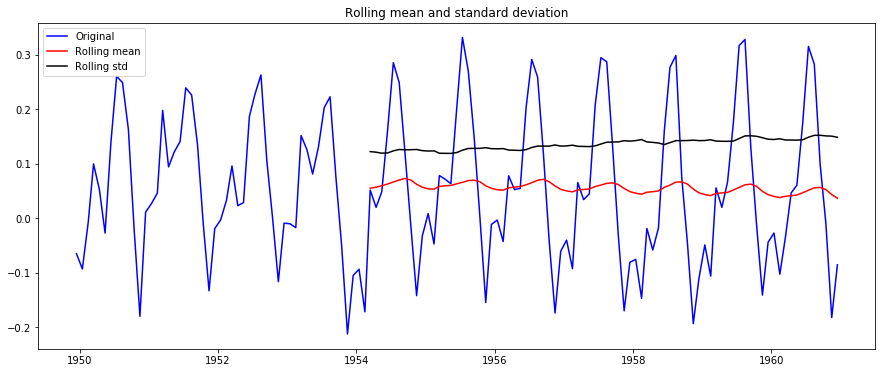

Results of Dickey Fuller test:
Test Statistic                  -3.162908
p-value                          0.022235
#lags used                      13.000000
Number of observations used    119.000000
Critical value(1%)              -3.486535
Critical value(5%)              -2.886151
Critical value(10%)             -2.579896
dtype: float64


In [76]:
# now let's parse our time series data into this function and check for stationarity
test_stationarity(ts_log_mv_diff)

 the result of dickey fuller test shows that the 'test statistic' < '1% of critical value'. That tells us that we r 99% 
 confident that this series is stationary. we can reject the null hypothesis.
  recap
     step 1> perform exploratory data analysis
     step 2> perform decomposition of data
     step 3> perform stationary check 

Problem Statement: The Air Passenger dataset provides monthly total of US airline passengers, from 1949 to 1960. This dataset is of a time series class
Objective:
•
Perform ARIMA modelingin Python after obtaining ACF and PACF plots

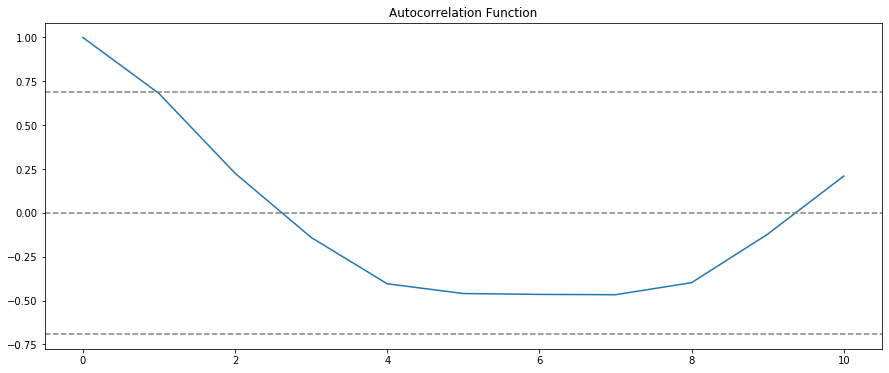

In [77]:
plt.plot(np.arange(0,11),acf(ts_log_mv_diff,nlags=10)) # plotting acf
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')# calculating the axis
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title("Autocorrelation Function")
plt.show()
# the afc curve crosses the upper confidence value when the lag value is between 0 and 1. Thus the optimal value of q in 
# ARIMA model must be 0 or 1. 

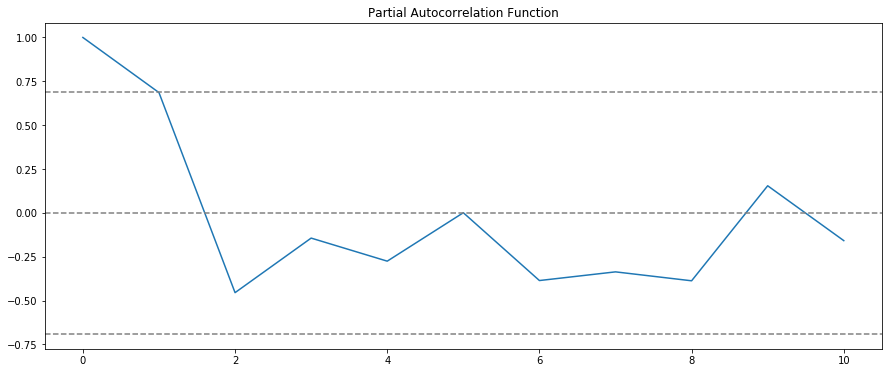

In [78]:
# plotting PACF
plt.plot(np.arange(0,11),pacf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')# calculating the axis
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title("Partial Autocorrelation Function")
plt.show()
# The PACF curve drops to 0 between lag value 1 and 2. Thus the optimal value of p in ARIMA model is 1 or 2 point pi.

Text(0.5, 1.0, 'RSS: nan')

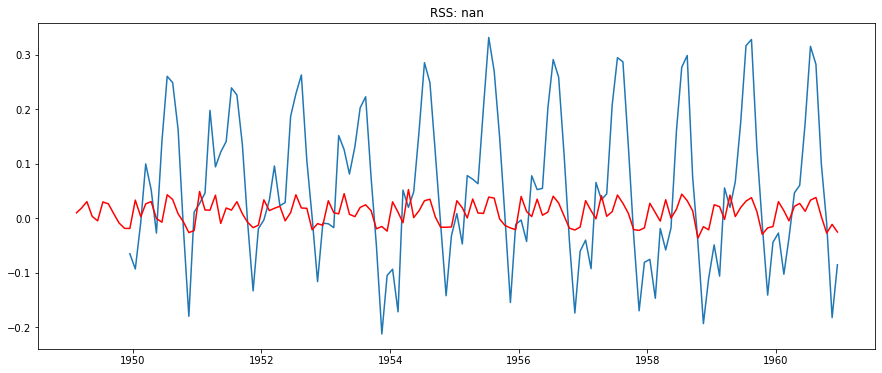

In [79]:
model=ARIMA(ts_log,order=(1,1,0))
results_Arima=model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(results_Arima.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((results_Arima.fittedvalues[1:] - ts_log_mv_diff)**2))

In [80]:
# model predictions
predictions_Arima_diff=pd.Series(results_Arima.fittedvalues,copy=True)
predictions_Arima_diff.head()
# we have stored predicted results in separate series to observe it. Note that these start from 1949-02-15 and not by 1st 
# month because we took a lag by 1. In the first element does not have anything before to subtract from. The way to convert
# differencing to log scale is to add these differences consecutively to the base number and easier way to do is first
# determine cumulative sum at index and then add it to the base number. 

Month
1949-02-15    0.009676
1949-03-15    0.018164
1949-04-15    0.030130
1949-05-15    0.003154
1949-06-15   -0.005039
dtype: float64

In [81]:
# Cumulative sum can be found as
predictions_Arima_diff_cumsum=predictions_Arima_diff.cumsum()
predictions_Arima_diff_cumsum.head()

Month
1949-02-15    0.009676
1949-03-15    0.027839
1949-04-15    0.057969
1949-05-15    0.061123
1949-06-15    0.056084
dtype: float64

In [82]:
predictions_Arima_log=pd.Series(ts_log.iloc[0],index=ts_log.index)
predictions_Arima_log=predictions_Arima_log.add(predictions_Arima_diff_cumsum,fill_value=0)
predictions_Arima_log.head()
# Finally we have forecast on original scale. 

Month
1949-01-15    4.718499
1949-02-15    4.728175
1949-03-15    4.746338
1949-04-15    4.776468
1949-05-15    4.779622
dtype: float64

Text(0.5, 1.0, 'RMSE: 374.7019')

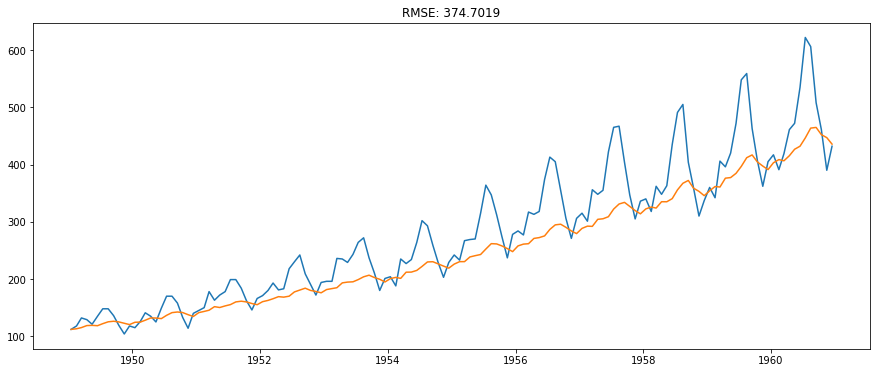

In [85]:
# initializing ARIMA model and plotting ARIMA predictions, assigning RMSE value as plot title.
predictions_Arima = np.exp(predictions_Arima_log)
plt.plot(ts)
plt.plot(predictions_Arima)
plt.title('RMSE: %.4f'%np.sqrt((sum(predictions_Arima-ts)**2)/len(ts)))
# The orange curve is our prediction which has RMSE of 52.1841. Our model is good at predicting the trend, it fails in 
# capturing the seasonality. 

Recap: 
step 1> perform exploratory data analysis
step 2> perform decomposition of data
step 3> perform stationary check 
step 4> fit a model using ARIMA algorithm 
step 5> calculate forecacts

Problem Statement: TheBeer production dataset provides a time series data for monthly beer production in Australia, for the period Jan 1956 –Aug 1995.
Objective:
•
Check for the stationarity of your data using Rolling Statistics and Dickey fuller test
•
if stationarity is present, remove it using differencing in Python

In [86]:
# Step 1: Data Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from datetime import datetime
%matplotlib inline
df=pd.read_csv("C:/Users/sharv/Documents/Post Graduate Program In Data Science-PurdueSimpliLearn/Course3-Machine Learning/Demo Datasets/Lesson 8/monthly-beer-production-in-austr.csv")
df.head()

,Month,Monthly beer production in Australia
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


Text(0, 0.5, 'Consumption in megalitres')

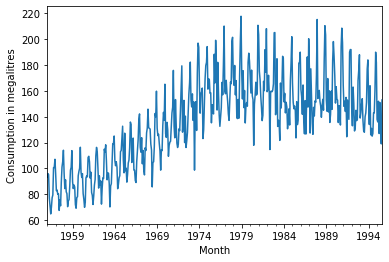

In [87]:
# Step 2: Parse and Plot
dateparse1 = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data1 = pd.read_csv('C:/Users/sharv/Documents/Post Graduate Program In Data Science-PurdueSimpliLearn/Course3-Machine Learning/Demo Datasets/Lesson 8/monthly-beer-production-in-austr.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse1)
ts1= data1['Monthly beer production in Australia']
ts1.plot()
plt.ylabel("Consumption in megalitres")

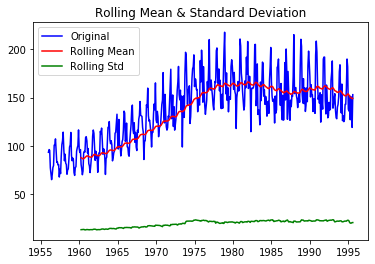

Results of Dickey-Fuller Test:
Test Statistic                 -2.282661
p-value                         0.177621
#LagsUsed                      17.000000
Numberof Observations Used    458.000000
Critical Value (1%)            -3.444709
Critical Value (5%)            -2.867871
Critical Value (10%)           -2.570142
dtype: float64


In [88]:
# Step 3: Stationarity Check
from statsmodels.tsa.stattools import adfuller
def test_stationarity1(timeseries1):
#Determing rolling statistics
    rolmean= timeseries1.rolling(window=52,center=False).mean()
    rolstd= timeseries1.rolling(window=52,center=False).std()
#Plot rolling statistics:
    orig= plt.plot(timeseries1, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
#Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest1= adfuller(timeseries1, autolag='AIC')
    dfoutput1= pd.Series(dftest1[0:4], index=['Test Statistic','p-value','#LagsUsed','Numberof Observations Used'])
    for key,value in dftest1[4].items():
        dfoutput1['Critical Value (%s)'%key] = value
    print (dfoutput1)
test_stationarity1(data1['Monthly beer production in Australia'])

The test statistic is more than critical value and the moving average is not constant over time.
So, the null hypothesis of the Dickey-Fuller test cannot be rejected.
This shows that the time series is not stationary.

Month
1956-01-01   NaN
1956-02-01   NaN
1956-03-01   NaN
1956-04-01   NaN
1956-05-01   NaN
Name: Monthly beer production in Australia, dtype: float64

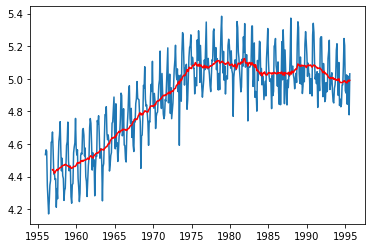

In [89]:
# Step 4: Stationarize
ts_log1 = np.log(ts1)
movingAverage1=ts_log1.rolling(window=12).mean()
movingSTD1=ts_log1.rolling(window=12).std()
plt.plot(ts_log1) # plotting the data
plt.plot(movingAverage1,color='red') # plotting the moving avg
# ts_log_mv_diff= pd.rol(data['Monthly beer production in Australia'].apply(lambda x: math.log(x)),2).diff(1)
ts_log_mv_diff1=ts_log1 - movingAverage1
ts_log_mv_diff1.head()

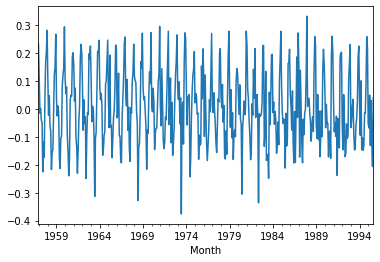

In [90]:
ts_log_mv_diff1.dropna(inplace=True)
ts_log_mv_diff1.plot()

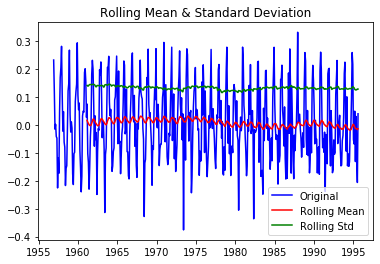

Results of Dickey-Fuller Test:
Test Statistic                 -3.432559
p-value                         0.009898
#LagsUsed                      13.000000
Numberof Observations Used    451.000000
Critical Value (1%)            -3.444933
Critical Value (5%)            -2.867970
Critical Value (10%)           -2.570195
dtype: float64


In [91]:
test_stationarity1(ts_log_mv_diff1)

Test statistic < 5 % of critical value. Rejectnull hypothesis

Objective:
•
Perform ARIMA modelingin Python after obtaining ACF and PACF plots

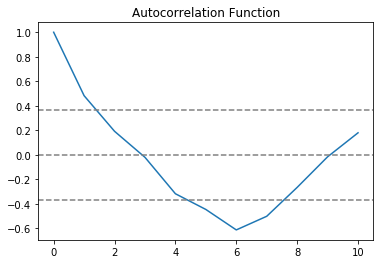

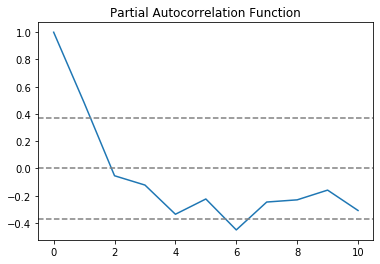

In [92]:
# ACF and PACF

plt.plot(np.arange(0,11), acf(ts_log_mv_diff1, nlags= 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff1)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff1)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff1, nlags= 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff1)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff1)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

ACFcurve crosses the upper confidence value when the lag value is between 0 and 1 Thus, optimal value of q in the ARIMA model must be 0 or 1
The PACFcurve drops to 0 between lag values 1 and 2
Thus, optimal value of p in the ARIMA model is 1 or 2

Text(0.5, 1.0, 'RSS: 0.0205')

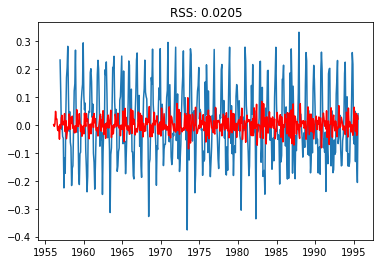

In [99]:
# ARIMA

model1 = ARIMA(ts_log1, order=(1, 1, 0)) 
results_Arima1= model1.fit(disp=-1) 
plt.plot(ts_log_mv_diff1) 
plt.plot(results_Arima1.fittedvalues, color='red') 
plt.title('RSS: %.4f'% (((results_Arima1.fittedvalues[1:] -ts_log_mv_diff1)**2).mean()))


In [100]:
predictions_ARIMA_diff1= pd.Series(results_Arima1.fittedvalues, copy=True) 
predictions_ARIMA_diff1.head()


Month
1956-02-01    0.000936
1956-03-01   -0.005458
1956-04-01    0.003012
1956-05-01    0.048189
1956-06-01    0.019847
dtype: float64

In [101]:
predictions_ARIMA_diff_cumsum1= predictions_ARIMA_diff1.cumsum() 
predictions_ARIMA_diff_cumsum1.head()


Month
1956-02-01    0.000936
1956-03-01   -0.004522
1956-04-01   -0.001510
1956-05-01    0.046680
1956-06-01    0.066527
dtype: float64

In [102]:
predictions_ARIMA_log1= pd.Series(ts_log1.iloc[0], index=ts_log1.index) 
predictions_ARIMA_log1= predictions_ARIMA_log1.add(predictions_ARIMA_diff_cumsum1,fill_value=0) 
predictions_ARIMA_log1.head()

Month
1956-01-01    4.534748
1956-02-01    4.535684
1956-03-01    4.530226
1956-04-01    4.533238
1956-05-01    4.581428
dtype: float64

Text(0.5, 1.0, 'RMSE: 2.3837')

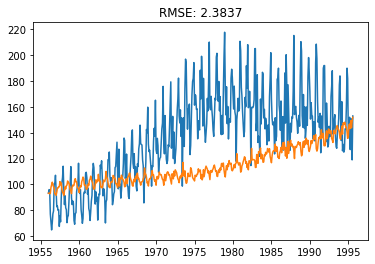

In [103]:
# ARIMA

predictions_Arima1= np.exp(predictions_ARIMA_log1)
plt.plot(ts1)
plt.plot(predictions_Arima1)
plt.title('RMSE: %.4f'% np.sqrt(((predictions_Arima1-ts1)**2)/(ts1)).mean())
# he got RMSE 37.12